In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [160]:
Q = 19.4e6 #metric tons of CO2 per 1 year (2019)

anthropogenic = 3.724e-5 #emission rate of CO2 per unit area (mol m^-2 s^-1)
#height = 1000 #boudary layer height
dy = 19377.8 #length of box (m)
dx = dy #width of box
Cup_ppm= 415#CO2 concentration for upwind box
Cent_ppm = 410#CO2 concentration above boundary layer
u = 3#wind speed in m/s
rho = dy/u #residence time of air over the area of the box (lateral length of box / wind speed)

ppm_to_mol = lambda x: x/10**6*44.01/.0224
mol_to_ppm = lambda x: x*10**6/44.01*.0224
Cup_mol = ppm_to_mol(Cup_ppm)
Cent_mol = ppm_to_mol(Cent_ppm)
sec_to_hour = lambda x: x/60/60

a = 0
b = 5e5
N = 1000
h = (b - a)/N
dhdt = 1e-6

(0.0, 24.0)

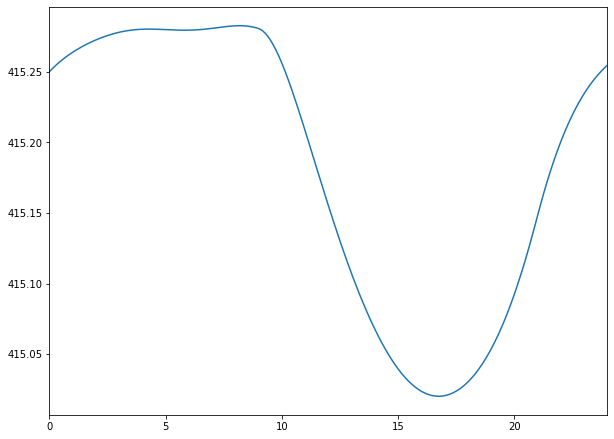

In [161]:
def CO2(Cbl,t):
    q = anthropogenic - anthropogenic*photosynthesis(t)
    return q/harmonic(t/60/60) + 1/rho*(Cup_mol - Cbl) + 1/harmonic(t/60/60)*dhdt*(Cent_mol-Cbl)

tpoints = np.arange(a,b,h)
xpoints = []
x = ppm_to_mol(415.25)

for t in tpoints:
    xpoints.append(x)
    k1 = h*CO2(x,t)
    k2 = h*CO2(x+0.5*k1,t+0.5*h)
    k3 = h*CO2(x+0.5*k2,t+0.5*h)
    k4 = h*CO2(x+k3,t+h)
    x += (k1+2*k2+2*k3+k4)/6  

xpoints_ppm = [mol_to_ppm(i) for i in xpoints]
tpoints_hour = [sec_to_hour(i) for i in tpoints]

plt.figure(figsize=(10,7.5))   
plt.plot(tpoints_hour,xpoints_ppm)
plt.xlim(0,24)


(0.0, 24.0)

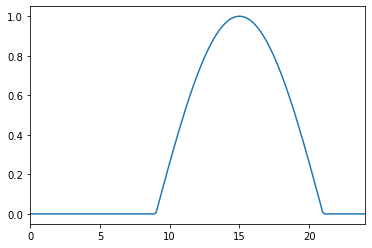

In [149]:
def photosynthesis(t):
    value = np.sin(2*np.pi/86400*t-.75*np.pi)
    if value < 0:
        return 0
    else:   
        return value

photo_points = [photosynthesis(i) for i in tpoints]
photo_points_hour = [sec_to_hour(i) for i in photo_points]
plt.plot(tpoints_hour, photo_points)
plt.xlim(0,24)

Text(0.5, 1.0, 'Boundary Layer Height')

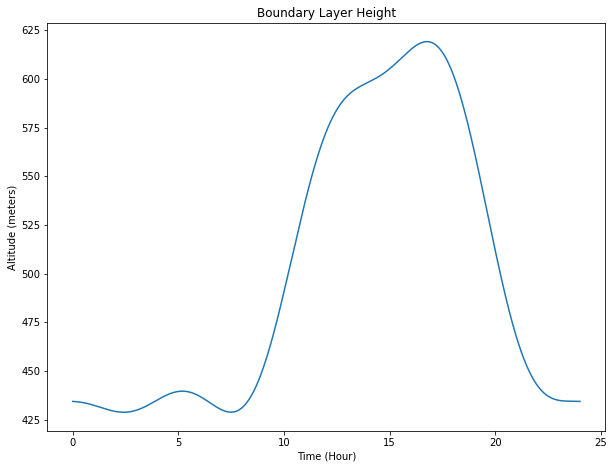

In [104]:
def harmonic(t):
    m = 4
    ak = [75.2235, -29.1925, -7.4486, 1.9185]
    bk = [62.8391, 8.0102, 6.5066, -11.6844]
    a0 = 500
    sum = 0
    for i in range(m):
        sum -= ak[i]*np.sin(2*np.pi*(i+1)*t/(24)) + bk[i]*np.cos(2*np.pi*(i+1)*t/(24))
    sum += a0
    return sum 

hours_to_seconds = lambda x: x*60*60
t = np.linspace(0,24,1000)
t_seconds = [hours_to_seconds(i) for i in t]
harmonic_seconds = [harmonic_inverse(i) for i in t]
plt.figure(figsize=(10,7.5))
plt.plot(t, harmonic_seconds)
plt.xlabel("Time (Hour)")
plt.ylabel("Altitude (meters)")
plt.title("Boundary Layer Height")

,Unnamed: 0,Time,ppm_x,DecTime,Day,ppm_y,anomaly,z_score,SMA_60,SMA_60_Anomaly
0,0,2021-01-20 10:21:00,485,10.350000,120,509.604396,-24.604396,-0.919184,483.333333,-26.271062
1,1,2021-01-20 10:22:00,497,10.366667,120,509.604396,-12.604396,-0.470881,483.451613,-26.152783
2,2,2021-01-20 10:23:00,507,10.383333,120,509.604396,-2.604396,-0.097296,483.375000,-26.229396
3,3,2021-01-20 10:24:00,502,10.400000,120,509.604396,-7.604396,-0.284089,483.060606,-26.543790
4,4,2021-01-20 10:25:00,499,10.416667,120,509.604396,-10.604396,-0.396164,482.823529,-26.780866
...,...,...,...,...,...,...,...,...,...,...
31079,31566,2021-02-11 08:27:00,589,8.450000,211,553.751953,35.248047,1.316815,580.200000,26.448047
31080,31567,2021-02-11 08:28:00,589,8.466667,211,553.751953,35.248047,1.316815,579.588235,25.836282
31081,31568,2021-02-11 08:29:00,577,8.483333,211,553.751953,23.248047,0.868512,578.909091,25.157138
31082,31569,2021-02-11 08:30:00,574,8.500000,211,553.751953,20.248047,0.756437,577.843750,24.091797


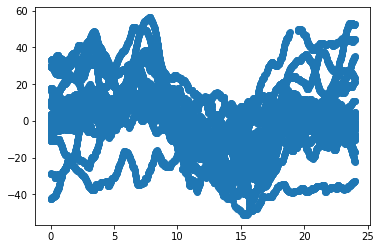

In [15]:
df = pd.read_csv('co2.csv')
plt.scatter(df.DecTime, df.SMA_60_Anomaly)
df

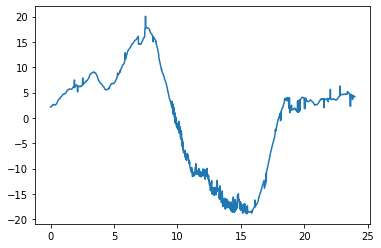

In [16]:
means = df[['DecTime','SMA_60_Anomaly']]
means = means.groupby('DecTime').mean()
means = means.reset_index()
plt.plot(means.DecTime,means.SMA_60_Anomaly)

class:  ndarray
shape:  (72000,)
strides:  (8,)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  True
data pointer: 0x1c393300080
byteorder:  little
byteswap:  False
type: float64


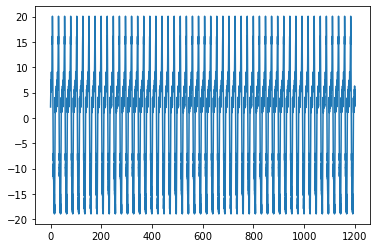

In [17]:
means_time = np.linspace(0,24*50,1440*50)
means_ppm = np.array(means.SMA_60_Anomaly)

means_ppm_tile = np.tile(means_ppm, 50)
np.info(means_ppm_tile)
plt.plot(means_time, means_ppm_tile)

F:\Anaconda\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(0.0, 1000.0)

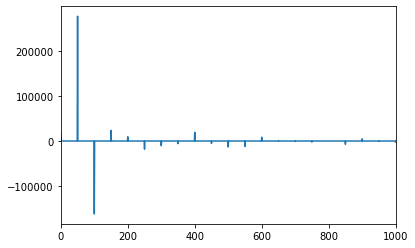

In [18]:
fft = np.fft.rfft(means_ppm_tile)
plt.plot(fft)
plt.xlim(0,1000)

[-162058.59890193+214603.46852298j       0.             +0.j
   16479.58348901     +0.j          277355.71797616-319644.54471664j]


F:\Anaconda\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


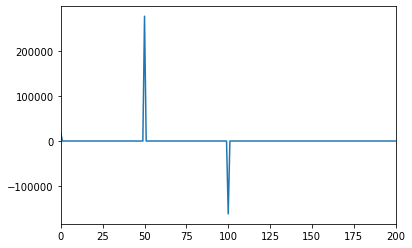

In [26]:
for i in range(len(fft)):
    if abs(fft[i]) < 1e-6:
        fft[i] = 0
    elif i < 150:
        pass
    
    else:
        fft[i] = 0

plt.plot(fft)
plt.xlim(0,200)
print(np.unique(fft))

(0.0, 48.0)

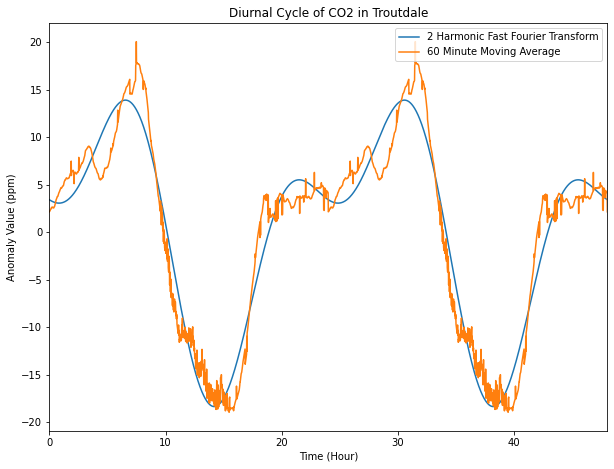

In [70]:
ifft = np.fft.irfft(fft)
plt.figure(figsize=(10,7.5))
plt.plot(means_time, ifft, label = "2 Harmonic Fast Fourier Transform")
plt.plot(means_time, means_ppm_tile, label = "60 Minute Moving Average")
plt.legend()
plt.title("Diurnal Cycle of CO2 in Troutdale")
plt.xlabel("Time (Hour)")
plt.ylabel("Anomaly Value (ppm)")
plt.xlim(0,48)